In [75]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.svm import SVC, SVR
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Data

In [2]:
raw_data = pd.read_csv('epi_r.csv')

In [3]:
# First lets look at the ratings.
raw_data.rating.value_counts()

4.375    8019
3.750    5169
5.000    2719
0.000    1836
3.125    1489
2.500     532
1.250     164
1.875     124
Name: rating, dtype: int64

In [4]:
np.diff(np.array([0.0, 1.25, 1.875, 2.5, 3.125, 3.75, 4.375, 5.0]))

array([1.25 , 0.625, 0.625, 0.625, 0.625, 0.625, 0.625])

Since the ratings are actually discrete, a classifier makes more sense. Note that the rating levels are not uniformly distributed. 

First lets add a binary feature to indicate if the recipe lists calories that are in the top 75% of all ratings, as well as some group some highly correlated features.

# Split

In [5]:
from sklearn.model_selection import train_test_split
X = raw_data.dropna().drop(['rating', 'title'], axis = 1)
X_test, X_train, y_test, y_train = train_test_split(X, raw_data.dropna().rating, test_size=0.70)

(array([ 892.,    0.,   83.,   56.,    0.,  293.,  806., 2895., 4601.,
        1479.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <a list of 10 Patch objects>)

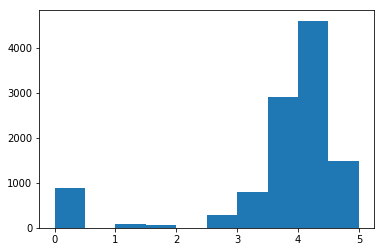

In [6]:
plt.hist(y_train)

In [7]:
# lets see what features are extrmely correlated
cm = X_train.corr()
s = cm.unstack()
so = s[s!=1.0].sort_values(kind="quicksort", ascending=False)
so[so>=0.7]

fat            calories         0.999977
calories       fat              0.999977
fat            sodium           0.999857
sodium         fat              0.999857
               calories         0.999793
calories       sodium           0.999793
soy free       peanut free      0.939265
peanut free    soy free         0.939265
pescatarian    kosher           0.882544
kosher         pescatarian      0.882544
alcoholic      drink            0.853555
drink          alcoholic        0.853555
protein        calories         0.835902
calories       protein          0.835902
protein        fat              0.832247
fat            protein          0.832247
sodium         protein          0.827546
protein        sodium           0.827546
peanut free    tree nut free    0.820729
tree nut free  peanut free      0.820729
soy free       tree nut free    0.790030
tree nut free  soy free         0.790030
portland       oregon           0.769592
oregon         portland         0.769592
pescatarian    v

In [8]:
# features to combine* (binary interaction)
features1 = ['calories', 'calories', 'sodium', 'peanut free', 
             'pescatarian', 'drink', 'peanut free', 'portland', 
             'soy free', 'sodium', 'vegetarian', 'snack week', 
             'pescatarian', 'kosher', 'peanut free', 'peanut free', 
             'soy free', 'calories', 'brunch', 'kentucky', 'denver', 
             'louisiana', 'new orleans']

features2 = ['sodium', 'fat', 'fat', 'soy free', 'kosher', 'alcoholic', 
             'tree nut free', 'oregon', 'tree nut free', 'protein', 
             'pescatarian', 'snack', 'soy free', 'vegetarian', 
             'pescatarian', 'kosher', 'kosher', 'protein', 'breakfast', 
             'louisville', 'omelet', 'kitchen olympics', 'louisiana']

for a,b in zip(features1, features2):
    X_train[a + "_" + b] = X_train[a] * X_train[b]
    X_test[a + "_" + b] = X_test[a] * X_test[b]

# Feature Selection  
## Random Forest  

We will first predict how likely the recipe is a high (>=2.5 rating) or low (<2.5), and given this predicted probability we can feed the data to a further model (2 layer).

In [9]:
X_train_dummy = pd.get_dummies(X_train)
# convert all columns to int's and make source_pc binary
X_train_dummy = X_train_dummy.astype(int)

**High or Low rating?** (<= 2.5)

In [10]:
# Features & Target
y_low = y_train <= 2.5

#Pipeline Construction.
anova_low = SelectKBest(f_classif, k=30)
svc_low = SVC(kernel='linear')
anova_svc = make_pipeline(anova_low, svc_low)

In [16]:
#Fitting & Cross-Validation.
anova_svc.fit(X_train_dummy,y_low)
scores_low = cross_val_score(anova_svc, X_train_dummy, y_low, cv=5)

#De-Masking Selected Features.
features_low = anova_low.get_support(indices=True)
selected_features_low = list(X_train_dummy.columns[features_low])

#Printing Outcomes.
print('Cross-Validation Scores: {}'.format(scores_low))
print('Cross-Validation Score Averaged Across Folds: {:.2%}.\n'.format(scores_low.mean()))
print('Selected Features: {}\n'.format(selected_features_low))

Cross-Validation Scores: [0.88388839 0.88788834 0.88293561 0.88608735 0.88243243]
Cross-Validation Score Averaged Across Folds: 88.46%.

Selected Features: Index(['alcoholic', 'bake', 'bitters', 'bon appétit', 'brandy', 'chile pepper',
       'cocktail', 'cocktail party', 'condiment', 'créme de cacao', 'drink',
       'fall', 'gin', 'harpercollins', 'house & garden', 'liqueur',
       'non-alcoholic', 'peanut free', 'roast', 'rum', 'rye', 'sauté',
       'soy free', 'spirit', 'tree nut free', 'vegan', 'weelicious', 'winter',
       'peanut free_soy free', 'drink_alcoholic'],
      dtype='object')



In [76]:
svc_1ow = SVC()
X_low = X_train[selected_features_low]
svc_1ow.fit(X_low,y_low)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [38]:
scores_low = cross_val_score(svc_1ow, X_train[selected_features_low], y_low, cv=5)
print('Cross-Validation Scores: {}'.format(scores_low))
print('Cross-Validation Score Averaged Across Folds: {:.2%}.\n'.format(scores_low.mean()))

Cross-Validation Scores: [0.88613861 0.89104007 0.88608735 0.88833859 0.88468468]
Cross-Validation Score Averaged Across Folds: 88.73%.



In [77]:
y_pred_train = svc_1ow.predict(X_train[selected_features_low]).astype(int)

This model simply predicts if the given recipe will be rated high or low. Let's see how it performs on the test set.  

In [80]:
#Clasification report
results_train = metrics.classification_report(y_true=(y_train<=2.5).astype(int), y_pred=y_pred_train)
print(results_train)

              precision    recall  f1-score   support

           0       0.89      1.00      0.94      9781
           1       0.86      0.07      0.13      1324

   micro avg       0.89      0.89      0.89     11105
   macro avg       0.88      0.54      0.54     11105
weighted avg       0.89      0.89      0.84     11105



### Evaluation

In [81]:
y_pred_test = svc_1ow.predict(X_test[selected_features_low])
#Clasification report
results_test = metrics.classification_report(y_true=(y_test<=2.5).astype(int), y_pred=y_pred_test)
print(results_test)

              precision    recall  f1-score   support

           0       0.89      1.00      0.94      4178
           1       0.84      0.07      0.13       581

   micro avg       0.88      0.88      0.88      4759
   macro avg       0.86      0.53      0.53      4759
weighted avg       0.88      0.88      0.84      4759



## Further classification  
The above model will predict whether or not the given recipe will be a low or high rating. If, instead, we want to predict the overall rating (7 levels from 0 to 5), we can still use a classifier, but this time with 8 possible outcomes. First let's define that mapping.

In [82]:
z = {0.0: 0, 1.25: 1, 1.875: 2, 2.5: 3, 3.125: 4, 3.75: 5, 4.375: 6, 5.0: 7}

In [83]:
# Features & Target
y = y_train.map(z)

#Pipeline Construction.
anova = SelectKBest(f_classif, k=30)
svc = SVC(kernel='linear')
anova_svc = make_pipeline(anova, svc)

#Fitting & Cross-Validation.
anova_svc.fit(X_train_dummy,y)
scores = cross_val_score(anova_svc, X_train_dummy, y, cv=5)
#De-Masking Selected Features.
features = anova.get_support(indices=True)  
selected_features = list(X_train_dummy.columns[features])

#Printing Outcomes.
print('Cross-Validation Scores: {}'.format(scores_low))
print('Cross-Validation Score Averaged Across Folds: {:.2%}.\n'.format(scores_low.mean()))
print('Selected Features: {}\n'.format(selected_features))

Cross-Validation Scores: [0.88613861 0.89104007 0.88608735 0.88833859 0.88468468]
Cross-Validation Score Averaged Across Folds: 88.73%.

Selected Features: ['alcoholic', 'bake', 'bitters', 'bon appétit', 'brandy', 'chile pepper', 'cocktail', 'cocktail party', 'condiment', 'drink', 'fall', 'fruit juice', 'gin', 'gourmet', 'harpercollins', 'house & garden', 'lime juice', 'liqueur', 'non-alcoholic', 'pasta', 'quick & easy', 'rum', 'sauce', 'sauté', 'spirit', 'tested & improved', 'thanksgiving', 'vegan', 'vegetable', 'drink_alcoholic']



In [54]:
svc2 = SVC(probability=True)
X = X_train[selected_features]
svc2.fit(X,y)

scores2 = cross_val_score(svc2, X_train[selected_features], y, cv=5)
print('Cross-Validation Scores: {}'.format(scores2))
print('Cross-Validation Score Averaged Across Folds: {:.2%}.\n'.format(scores2.mean()))

p_pred = svc2.predict_proba(X_test[selected_features])

Cross-Validation Scores: [0.42382022 0.43519352 0.429086   0.42721947 0.42921551]
Cross-Validation Score Averaged Across Folds: 42.89%.



In [85]:
y_pred_test = p_pred.argmax(axis=1)
#Clasification report
results = metrics.classification_report(y_true=y_test.map(z), y_pred=y_pred_test)
print(results)

              precision    recall  f1-score   support

           0       0.53      0.27      0.36       404
           1       0.00      0.00      0.00        40
           2       0.00      0.00      0.00        25
           3       0.00      0.00      0.00       112
           4       0.00      0.00      0.00       359
           5       0.00      0.00      0.00      1241
           6       0.43      0.98      0.59      1951
           7       0.39      0.03      0.06       627

   micro avg       0.43      0.43      0.43      4759
   macro avg       0.17      0.16      0.13      4759
weighted avg       0.27      0.43      0.28      4759



So this model is only ok with those recipes with a 0, 4.375 or 5 rating, which is likely a result of the original distribution of ratings (as well as other things). These groups have larger sample sizes, but it is interesting to notice that it was unable to classify any review with a rating of 3.75 even though this group has a relatively large group size.

In [89]:
raw_data.rating.value_counts().sort_index()

0.000    1836
1.250     164
1.875     124
2.500     532
3.125    1489
3.750    5169
4.375    8019
5.000    2719
Name: rating, dtype: int64